In [1]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import kneed
from collections import deque
import pygraphviz as pgv

In [2]:
DATASET = 'ss-role'
ITERATION = 20
DATASPLIT = 'train'
LAYER = 12

In [90]:
def read_labels(path, dataset='ss-role'):
    label_data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if dataset in ['ss-func', 'ss-role']:
                word_info, word_label = line.strip().split('\t')
                sent_info, word = word_info.split(':')
                sent_info = ast.literal_eval(sent_info)
                label_data.append([sent_info[0], sent_info[1], word, word_label])
            elif dataset == 'dep':
                word_pair, word_label = line.strip().split('\t')
                word_pair = word_pair.split('--')
                if len(word_pair) == 2:
                    word1, word2 = word_pair
                elif len(word_pair) == 3:
                    word1, word2 = word_pair[0], '--'
                sent_info = [0, 0]
                label_data.append([sent_info[0], sent_info[1], f'{word1}--{word2}', word_label])
            else:
                raise ValueError('Dataset not supported')

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def get_graph(dataset, dist_metric, filter, intervals, overlap, iteration, layer, datasplit):
    # make request to local server at port 5000 at \graph
    # with the query: {params: 'ss-role_euclidean_l2_50_50', iteration: 0, layer: 12, datasplit: 'train'}
    # and save the response as a variable
    r = requests.get(
        'http://localhost:5000/graph',
        params={'params': f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}', 'iteration': iteration, 'layer': layer,
                'datasplit': datasplit})
    data = r.json()
    graph = nx.json_graph.node_link_graph(data['graph'])
    return graph


def get_activations(dataset, iteration, layer, datasplit):
    activations = pd.read_csv(
        f'../backend/data/{dataset}/fine-tuned-bert-base-uncased/{datasplit}/{iteration}/{layer}.txt', delim_whitespace=True, header=None)
    labels = read_labels(f'../backend/data/{dataset}/entities/{datasplit}.txt', dataset=dataset)

    return activations, labels


def point_to_node(nodes, num_points=4282):
    ptn_dict = {}
    for point_idx in range(num_points):
        for node_idx, node in enumerate(nodes):
            node_data = nodes[node]['membership']['membership_ids']

            if point_idx in node_data:
                ptn_dict[point_idx] = node_idx

    return ptn_dict


def linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix


def plot_dendrogram(model):
    linkage_mat = linkage_matrix(model)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_mat, orientation='left', truncate_mode='level', p=8, leaf_font_size=12, leaf_label_func=leaf_label)


def leaf_label(idx):
    if idx < len(labels):
        return labels.iloc[idx]['label']
    else:
        return 'None'


def elbow_eps(data):
    nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)[::-1]
    kneedle = kneed.KneeLocator(distances[:, 1], np.linspace(0, 1, num=len(distances)), curve='convex', direction='decreasing')
    eps = kneedle.knee * 0.75
    return eps


def populate_tree_labels(treeNode):
    if treeNode.id < len(labels):
        treeNode.label = set([labels.iloc[treeNode.id]['label'].split('.')[1]])
    else:
        # popluate children
        populate_tree_labels(treeNode.left)
        populate_tree_labels(treeNode.right)

        # label is union of labels of left and right children
        treeNode.label = treeNode.left.label | treeNode.right.label

    return treeNode


def process_label(label, max_length=15):
    label_str = ','.join(sorted(label))
    if len(label_str) > max_length:
        return f'{label_str[:max_length]}... ({len(label)})'
    else:
        return label_str


def bfs_traversal(treeNode, graph, max_level=5):
    q = deque()

    q.append(treeNode)
    level = 0

    while len(q) > 0 and level < max_level:
        level_size = len(q)

        for _ in range(level_size):
            node = q.popleft()
            num_labels = len(node.label)

            graph.add_node(node.id, label=process_label(node.label))

            # terminate if node's label has one label
            if num_labels > 1:
                if node.left is not None:
                    q.append(node.left)
                    graph.add_edge(node.id, node.left.id, weight=node.left.dist)
                    graph.add_node(node.left.id, label=process_label(node.left.label))


                if node.right is not None:
                    q.append(node.right)
                    graph.add_edge(node.id, node.right.id, weight=node.right.dist)
                    graph.add_node(node.right.id, label=process_label(node.right.label))

        level += 1


def node_to_point_matrix(activations, ptn_dict, node_dist_matrix):
    point_dist_mat_from_graph = np.zeros((len(activations), len(activations)))

    # populate point_dist_mat_from_graph
    for point_idx1 in range(len(activations)):
        for point_idx2 in range(len(activations)):
            if point_idx1 not in ptn_dict or point_idx2 not in ptn_dict:
                point_dist_mat_from_graph[point_idx1][point_idx2] = 100
            elif point_idx1 != point_idx2:
                point_dist_mat_from_graph[point_idx1, point_idx2] = node_dist_matrix[ptn_dict[point_idx1], ptn_dict[point_idx2]]

    return point_dist_mat_from_graph


In [73]:

graph = get_graph(DATASET, 'euclidean', filter='l2', intervals=50, overlap=50, iteration=ITERATION, layer=LAYER, datasplit='train')
activations, labels = get_activations(DATASET, ITERATION, LAYER, 'train')

distance_matrix = nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(graph, weight='centroid_dist')
distance_matrix[np.isinf(distance_matrix)] = 100

ptn_dict = point_to_node(graph.nodes)
point_dist_mat_from_graph = node_to_point_matrix(activations, ptn_dict, distance_matrix)

In [74]:
model_aggclust_mapper = AgglomerativeClustering(n_clusters=None, distance_threshold=50, affinity='precomputed', linkage='average')
model_aggclust_mapper.fit(point_dist_mat_from_graph)

model_aggclust_act = AgglomerativeClustering(n_clusters=None, distance_threshold=50, linkage='average')
model_aggclust_act.fit(activations)

# model_dbscan_act = DBSCAN(eps=elbow_eps(activations), min_samples=1)
# model_dbscan_act.fit(activations)

AgglomerativeClustering(distance_threshold=50, linkage='average',
                        n_clusters=None)

In [93]:
lm = linkage_matrix(model_aggclust_mapper)
tree = to_tree(lm)
populate_tree_labels(tree)

linkage_graph = nx.DiGraph()
bfs_traversal(tree, linkage_graph, max_level=15)


In [94]:
Ag = nx.nx_agraph.to_agraph(linkage_graph)
Ag.layout(prog='neato')
Ag.draw('graph.svg', format='svg')

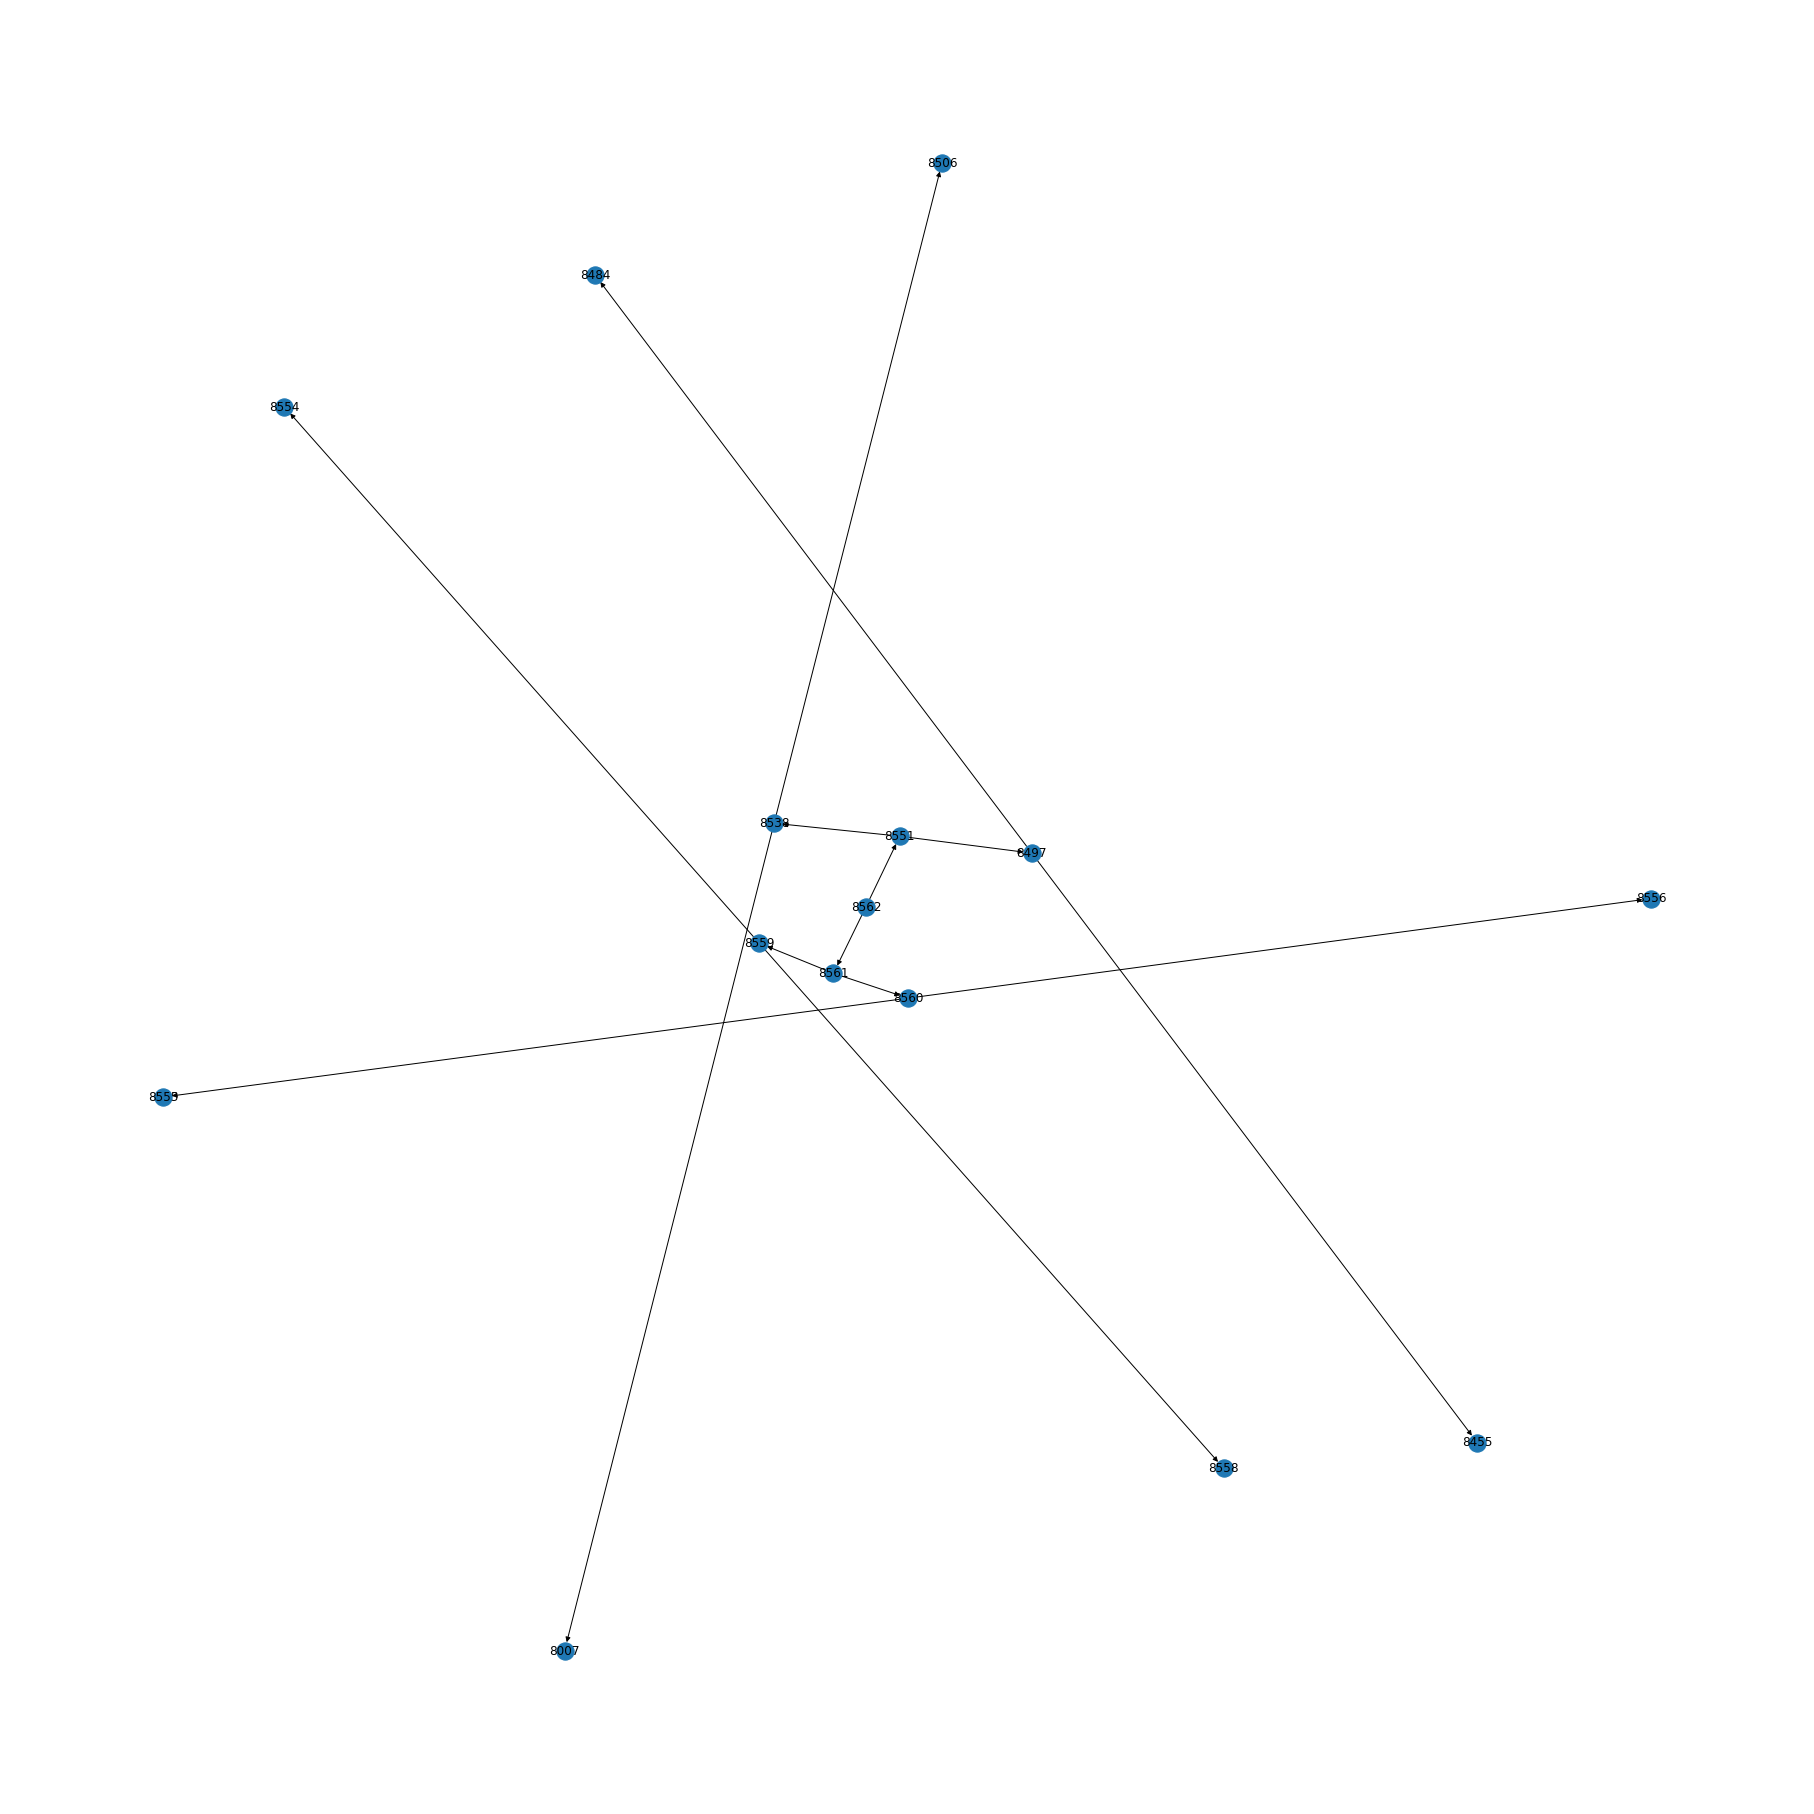

In [81]:
def get_processed_labels(linkage_graph):
    labels = nx.get_node_attributes(linkage_graph, 'label')
    for l in enumerate(labels):
        label_val = labels[l]

        if len(label_val) > 25:
            # count commas in l
            labels[l] = f'{label_val[:25]} ({label_val.count(",")})'

    return labels


plt.figure(figsize=(25, 25))

pos = nx.drawing.nx_pydot.graphviz_layout(linkage_graph, prog='dot')

# draw labels inside a box
# nx.draw(linkage_graph, pos, node_size=10, node_color='#cccccc', with_labels=True, font_size=8, font_weight='bold', labels=nx.get_node_attributes(linkage_graph, 'label'))
# nx.draw(linkage_graph, labels=nx.get_node_attributes(linkage_graph, 'label'), pos=pos, node_size=10, font_weight='bold', font_size=14)
# plt.savefig(f'linkage_graph_{ITERATION}.png', dpi=300)
nx.draw(linkage_graph, with_labels=True)


In [96]:
def plot_data(data, color):
    xy = pd.DataFrame(PCA(n_components=2).fit_transform(activations), columns=['x', 'y'])

    # plot scatterplot using seaborn
    sns.scatterplot(data=xy, x='x', y='y', hue=color, s=100, alpha=0.5)

    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(25, 20))
plot_data(activations, pd.Series(model_dbscan_act.labels_).astype(str))

NameError: name 'model_dbscan_act' is not defined

<Figure size 1800x1440 with 0 Axes>

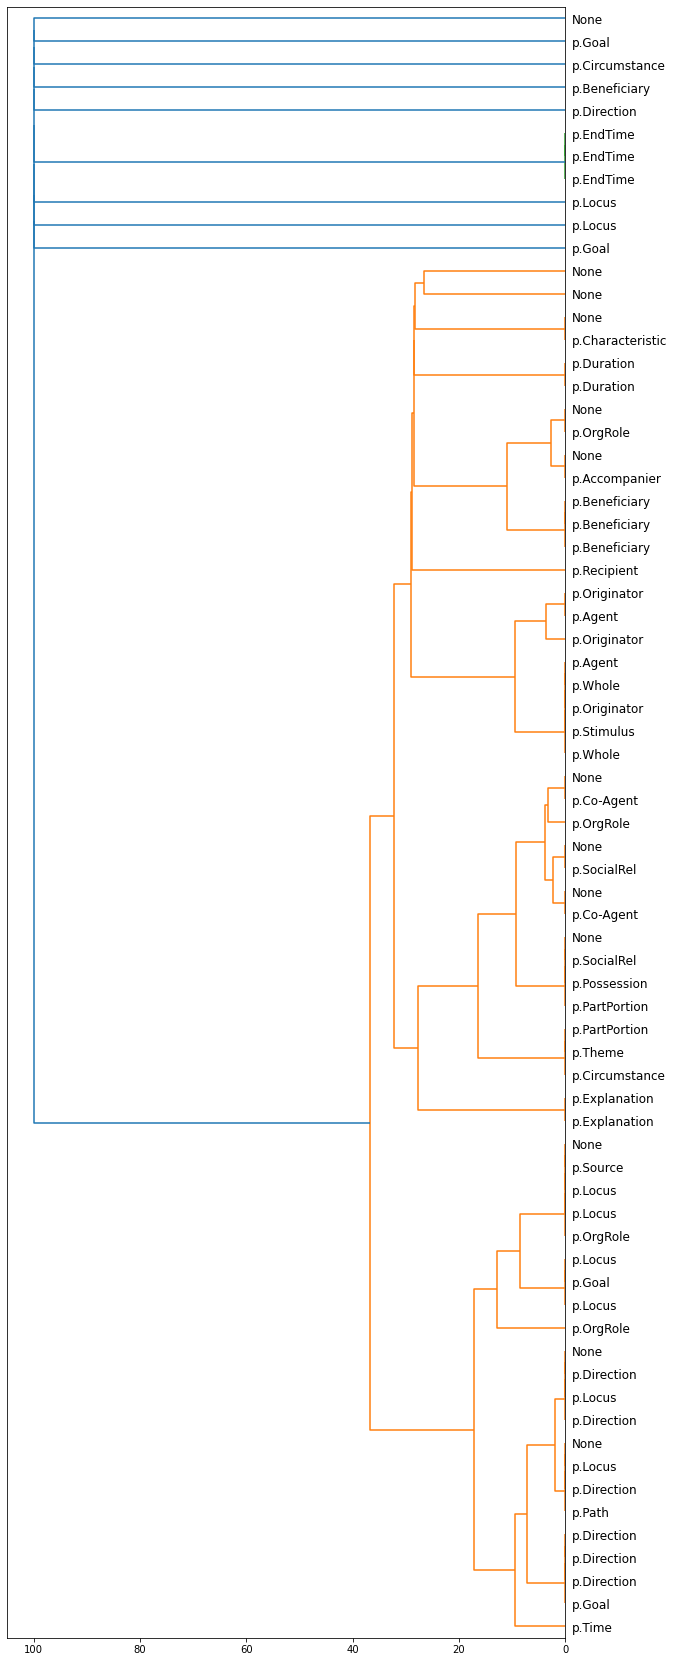

In [95]:
plt.figure(figsize=(10, 30))    
d_gram = plot_dendrogram(model_aggclust_mapper)